## Imports

In [1]:
# general imports 
import allensdk
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
%matplotlib inline 
from joblib import Parallel, delayed 
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy.stats import ttest_1samp
from tqdm import tqdm


# ephys analysis packages
from neo.core import SpikeTrain
from quantities import ms, s, Hz
from elephant.statistics import time_histogram, instantaneous_rate,  mean_firing_rate
from elephant.conversion import BinnedSpikeTrain
from elephant.spike_train_correlation import cross_correlation_histogram


# set data path
import sys
import platform
import os
from os.path import join as pjoin
from pathlib import Path
sys.path.insert(0, '/code/src')

# import our functions
# import importlib
# import plot_utils
# from data_utils import process_nwb_metadata, get_stim_window, get_spike_counts_all
# from plot_utils import plot_area_psth_and_raster, plot_multi_area_psth_and_raster, build_area_packet
# from plot_utils import create_raster, plot_area_psth_and_raster

## Load data from ALLEN SDK

In [2]:
platstring = platform.platform()
system = platform.system()
if system == "Darwin":
    # macOS
    data_dir = "/Volumes/Brain2025/"
elif system == "Windows":
    # Windows (replace with the drive letter of USB drive)
    data_dir = "E:/"
elif "amzn" in platstring:
    # then on CodeOcean
    data_dir = "/data/"
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_dir = "/media/$USERNAME/Brain2025/"
data_root = Path(data_dir)
print('data directory set to', data_dir)

data directory set to /data/


In [3]:
# Visual Behavior Neuropixels 
from allensdk.brain_observatory.behavior.behavior_project_cache.\
    behavior_neuropixels_project_cache \
    import VisualBehaviorNeuropixelsProjectCache

cache_dir = '/root/capsule/data/'

cache = VisualBehaviorNeuropixelsProjectCache.from_local_cache(
            cache_dir=cache_dir, use_static_cache=True)

/opt/conda/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Ephys beh. sessions data
ecephys_session_table = cache.get_ecephys_session_table() 

## Functions

In [13]:
def extract_relevant_session_info(cache, table_type='ecephys', verbose=False):
    # table_type: 'ecephys', 'ecephys_strict', 'behavior'
    
    if table_type == 'behavior':
        session_table = cache.get_behavior_session_table() 
        session_table_final = session_table[(session_table.session_type.str.startswith('EPHYS')) & 
                                            # (behavior_session_table.genotype=='wt/wt') & ## genotypes okay for ephys
                                            (session_table.session_type.str.contains('3uL')) ## 5 uL: not motivated long enough
                                            ]
    elif 'ecephys' in table_type:
        # Filter only for mice that are (i) trained on set G, (ii) tested on first G ('familiar'), then H ('novel').
        session_table = cache.get_ecephys_session_table() 
        session_table_final = session_table[((session_table.session_type.str.startswith('EPHYS')) 
                                                # & (behavior_session_table.genotype=='wt/wt')          ## genotypes okay for ephys
                                                & (session_table.session_type.str.contains('3uL')))     ## 5 uL: not motivated long enough
                                            & ((session_table.image_set=='G') 
                                                & (session_table.experience_level=='Familiar') 
                                                & (session_table.session_number==1)) 
                                            | ((session_table.image_set=='H') 
                                                & (session_table.experience_level=='Novel') 
                                                & (session_table.session_number==2))
                                            ]
        
        if 'strict' in table_type:
            # Get mice that only have both session types
            full_session_mice_idx = np.where(session_table_final['mouse_id'].value_counts()==2)[0]
            full_session_mice     = list(session_table_final['mouse_id'].value_counts().index[full_session_mice_idx])
            session_table_final   = session_table_final[session_table_final.mouse_id.isin(full_session_mice)]
    
    if verbose:
        print(f'Unique genotypes: {session_table_final.genotype.unique()}')
        print(f'Unique session types: {session_table_final[["session_type"]].value_counts()}')
        print(f'Number of sessions: {len(session_table_final)}')
        print(f'Number of mice: {session_table_final[["mouse_id"]].value_counts()}')
        
    return session_table_final



## Filter sessions based on performance metrics ##
def filter_valid_sessions(ecephys_session_table, thresh_perc_engaged = 0.6, thresh_dur_engaged = 0.6, verbose=False):
# thresh_perc_engaged = 0.6 # only sessions that have more than thresh_perc_engaged during engagement period are included in analysis [y-axis, stats 1]
# thresh_dur_engaged = 0.6 # only sessions that are engaged for longer than thresh_dur_engaged are included in analysis [x-axis, stat 2]

    ecephys_session_table['perc_last_disengagement'] = ecephys_session_table['trial_last_disengagement'] / ecephys_session_table['trial_number']

    valid_sessions = ecephys_session_table.loc[(ecephys_session_table.perc_engaged_strict > thresh_perc_engaged) \
                                                    & (ecephys_session_table.perc_last_disengagement > thresh_dur_engaged)]
    valid_session_ids = list(valid_sessions['behavior_session_id'].values)

    if verbose:
        print(f'Valid sessions ({len(valid_session_ids)})\n')
        print(valid_session_ids)

    return valid_sessions, valid_session_ids, ecephys_session_table



def select_good_units(session, snr=1, isi_violations=1, firing_rate=0.1):
    '''
    Create a df with good units by thresholding quality metrics and including recording sites.
    
    Parameters
    ----------
    - session: allenSDK ecephys session (from cache.get_ecephys_session)
    - snr: float. Minimum signal to noise ratio
    - isi_violations: float. Minimum inter spike interval violations
    - firing_rate: float. Minimun firing rate 
    
    Returns
    ----------
    pandas.DataFrame with all units that pass the threshold
    '''

    units = session.get_units()
    channels = session.get_channels()
    unit_channels = units.merge(channels, left_on='peak_channel_id', right_index=True)
    good_unit_filter = ((unit_channels['snr']>snr)&
                        (unit_channels['isi_violations']<isi_violations)&
                        (unit_channels['firing_rate']>firing_rate))
    good_units = unit_channels.loc[good_unit_filter]

    return good_units




def get_population_vectors(units, spike_times, event_start_times, event_end_times, time_before_event, time_after_event):
    '''
    Extracts the firing rates of certain units arround specific task events

    Parameters
    ----------
    - units: pandas.DataFrame contianing the good_units
    - spike_times: dictionary. keys units, values spiketimes over the whole session
    - event_start_times: array. Times when the desired event starts
    - event_end_times: array. Times when the desired event starts 
    - time_before_event: float. Extra time before event_start
    - time_before_event: float. Extra time after event_start

    
    Returns
    ----------
    List of arrays, Ntask_events, Nunits
    '''

    population_vectors = []
    for event_start, event_end in zip(event_start_times, event_end_times):
        rates = []
        for ui in units.index: # loop over the selected units
            spike_times_ui = spike_times[ui]
            onset_window   = event_start - time_before_event
            offset_window  = event_end + time_after_event
            assert offset_window > onset_window
            spike_times_ui_window = spike_times_ui[(spike_times_ui > onset_window) \
                                                    & (spike_times_ui < offset_window)]
            rate_ui = len(spike_times_ui_window) / (offset_window - onset_window) # calculate the mean firing rate
            rates.append(rate_ui)
        assert len(rates) == len(units)
        population_vectors.append(np.array(rates))
    return population_vectors

## Select session

In [14]:
# Get good behavioral sessions
ecephys_session_table_final = extract_relevant_session_info(cache, table_type='ecephys_strict', verbose=False)
ecephys_session_table_final.groupby('session_type')['experience_level'].unique()

session_type
EPHYS_1_images_G_3uL_reward    [Familiar]
EPHYS_1_images_H_3uL_reward       [Novel]
Name: experience_level, dtype: object

## Tests one session

In [8]:
# Get a single session
a_novel_session = cache.get_ecephys_session(ecephys_session_id=ecephys_session_table_final.index[0]) #extract data of the session
# Get only GOOD units
good_units_df = select_good_units(a_novel_session)

# Extract spike times 
spike_times_dic = a_novel_session.spike_times

/opt/conda/lib/python3.9/site-packages/hdmf/spec/namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.6.0-alpha, loaded version: 2.7.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)


In [ ]:
stimulus_presentations_df= a_novel_session.stimulus_presentations
stimulus_presentations_df['is_change_shift'] = stimulus_presentations_df['is_change'].shift(4)


In [ ]:
a_novel_session.loc[a_novel_session.loc[(a_novel_session['is_change']==True) & (a_novel_session['active']==True)]]


In [10]:
time_before_event = 0
time_after_event = 0
stimulus_presentations_df = a_novel_session.stimulus_presentations
stim_1_subset= stimulus_presentations_df.loc[(stimulus_presentations_df['image_name'] == 'im036_r') 
                                             & (stimulus_presentations_df['is_change'] == True)]

population_vectors= get_population_vectors(good_units_df, spike_times_dic, stim_1_subset.start_time.unique(), stim_1_subset.end_time.unique(),
                    time_before_event, time_after_event)
mean_fr_by_stim = [arr.mean() for arr in population_vectors if arr.size > 0] # Extract mean values
mean_fr_by_stim = np.array(mean_fr_by_stim) # to array Nstim presentations

In [ ]:
stimulus_presentations.start_time.values[:5]

## All sessions

In [35]:
n_jobs = 3 # match with your cores inizialized (max 3 --> max 110GB Mmeory)
subjects = ecephys_session_table_final.mouse_id.unique()[33:]
experience_level = ['Familiar', 'Novel']
shared_images = ['im083_r', 'im111_r'] # flowers in a pot # big leaf
max_event_n = 20 # number of repetitions of the same stimulus within the same session (usually ~60, take only the first oens to avoid diengagement)
time_before_event = 0
time_after_event = 0

# Inizialize array
shape = (len(subjects), len(experience_level), len(shared_images), max_event_n)
mean_fr_arr = np.full(shape, np.nan, dtype=float) # Preallocate result with NaNs


def compute_subject_mean_fr (idx_s, subj, experience_level, shared_images, max_event_n, time_before_event, time_after_event):
        """
        Returns a block of Nexperience_level, Nshared_images, Nmax_event_n)
        for a single subject, filled with NaNs where data is missing.
        """

        block_arr = np.full((len(experience_level), len(shared_images), max_event_n), np.nan, dtype=float)

        for idx_e, exp in enumerate(experience_level): #  Familiar vs novel session
        
                # Get session index
                mask = ((ecephys_session_table_final['mouse_id'] == subj) &
                        (ecephys_session_table_final['experience_level'] == exp))
                session_id = ecephys_session_table_final.loc[mask].index
                if len(session_id)>1:
                        print('Warning more than one session!')

                # Extract the data of the session
                session = cache.get_ecephys_session(ecephys_session_id=session_id[0])

                # Filter good units of the session
                good_units_df = select_good_units(session)

                # Extract all spike times of the session
                spike_times_dic = session.spike_times

                # Loop shared images
                for idx_i, image in enumerate(shared_images): # 2 shared images across recording days

                        mask = ((session.stimulus_presentations['image_name'] == image) &
                                (session.stimulus_presentations['is_change'] == True)) # get only changes
                        
                        # get starting and ending timestamps for each event (take only the first events to avoid disengagement)
                        event_start_times = session.stimulus_presentations.loc[mask].start_time.unique()[:max_event_n]
                        event_end_times = session.stimulus_presentations.loc[mask].end_time.unique()[:max_event_n]

                        # get 1D array with mean fr of all units for each event repetition
                        fr_stim_unit= get_population_vectors(good_units_df, spike_times_dic, event_start_times, event_end_times,
                                                                time_before_event, time_after_event)  # List of arrays, Ntask_events, Nunits
                        mean_fr_stim = [arr.mean() for arr in fr_stim_unit if arr.size > 0] # Extract means across units (as they are not shared across sessions we cannot keep their identities)
                        mean_fr_stim = np.array(mean_fr_stim) # 1D array Nreps

                        # store in an array  Nexp, Nimages, Nreps
                        block_arr[idx_e, idx_i, :] = mean_fr_stim 

        return idx_s, block_arr


# Run in parallel over subjects
results = Parallel(n_jobs=n_jobs, backend="loky")(delayed(compute_subject_mean_fr)(
        idx_s, subj, experience_level, shared_images, max_event_n,time_before_event, time_after_event)
    for idx_s, subj in tqdm(enumerate(subjects), total=len(subjects)))  

100%|██████████| 2/2 [00:00<00:00, 1846.08it/s]
/opt/conda/lib/python3.9/site-packages/hdmf/spec/namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.6.0-alpha, loaded version: 2.7.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)
/opt/conda/lib/python3.9/site-packages/hdmf/spec/namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.6.0-alpha, loaded version: 2.7.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)
/opt/conda/lib/pytho

In [36]:
# Extract only the 3D arrays
arrays = [arr for (_, arr) in results]
result_arr5 = np.stack(arrays, axis=0) # Stack them into one 4D array

In [37]:
#save the array
filename= 'mi_array_test5.npy'
path = '/root/capsule/resources/'
fullpath = os.path.join(path, filename)
np.save(fullpath, result_arr5)  

In [7]:
path = '/root/capsule/resources/'
result_arr1 =  np.load(os.path.join(path,'mi_array_test.npy'))  
result_arr2 =  np.load(os.path.join(path,'mi_array_test2.npy'))  
result_arr3 =  np.load(os.path.join(path,'mi_array_test3.npy')) 
result_arr4 =  np.load(os.path.join(path,'mi_array_test4.npy'))  
result_arr5 =  np.load(os.path.join(path,'mi_array_test5.npy'))  

result_arr = np.concatenate([result_arr1, result_arr2, result_arr3, result_arr4, result_arr5], axis=0)

#save all
#filename= 'mi_array_full.npy'
#np.save(os.path.join(path, filename), result_arr)  


In [8]:
A = result_arr[:, 0, :, :]   # context 0 : Familiar
B = result_arr[:, 1, :, :]   # context 1 : Novel
MI = (A - B) / (A + B)
#A_baseline = np.nanmean(A, axis=-1, keepdims=True)  # shape (Nsubj, Nimage, 1)  # mean across timepoints
#MI = (A_baseline - B) / (A_baseline + B)

In [9]:
# Reshape into tidy DataFrame  # MI array 3D Nsubjects, Nimages, Ntimestamps
max_event_n=20
timestamps= np.arange(max_event_n)
records = []
for subj in range(MI.shape[0]):
    for img in range(MI.shape[1]):
        for t in range(MI.shape[2]):
            records.append((timestamps[t], MI[subj, img, t], subj, img))

df = pd.DataFrame(records, columns=["timestamp", "mi", "subject", "image"])


In [15]:
# Include mouse ID
subjects = ecephys_session_table_final.mouse_id.unique()
df['mouse_id'] = df['subject'].map(lambda i: subjects[i]) # include mouse id


In [16]:
# IMport learning classification for each subject
mice_learning_table = pd.read_csv('/root/capsule/resources/mice_learning_table.csv')

17.0


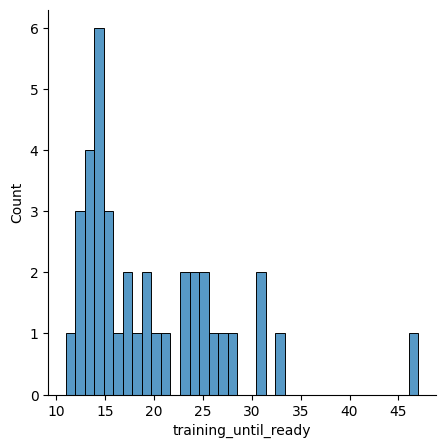

In [35]:
fig, ax = plt.subplots(figsize =(5,5))
sns.histplot(mice_learning_table.training_until_ready, bins=37)
median=mice_learning_table.training_until_ready.median()
print(median)
sns.despine()

In [18]:
# CLASSIFY LEARNING
median=mice_learning_table.training_until_ready.median()

slow_learners= mice_learning_table.loc[mice_learning_table['training_until_ready']>=median]['mouse_id'].values
fast_learners= mice_learning_table.loc[mice_learning_table['training_until_ready']<median]['mouse_id'].values
over_trained= np.array([574078, 544358, 560771, 570301, 563323, 548720, 548721, 532246,
       548715, 553960, 567286, 536211, 544837, 599294, 548465, 533537,
       545994, 553253, 546507, 574082, 544835, 536213, 536480, 530862,
       531237, 558306, 545996, 563497, 563326, 574081, 568963, 563495,
       546503, 553963, 570299, 527749, 524925, 524760, 540536, 521466,
       509808, 524926, 562033])

def learning_list(s, slow_learners, fast_learners, over_trained):
    if s in slow_learners:
        return 'slow'
    elif s in fast_learners:
        return 'fast'
    elif s in over_trained:
        return 'over'
    else:
        print(f'warning: non classified animal {s}')
        return 'non-class'

df['learning'] = df['mouse_id'].apply(
    lambda s: learning_list(s, slow_learners, fast_learners, over_trained))


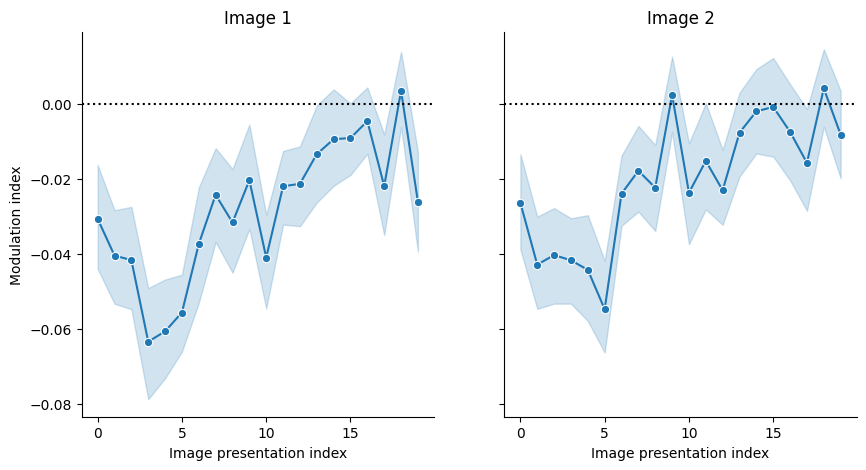

In [44]:
fig,ax = plt.subplots(ncols = 2, figsize =(10,5), sharex=True, sharey=True)

sns.lineplot(x='timestamp', y='mi',  data=df.loc[df['image']==0], marker='o', ax=ax[0], errorbar=('ci', 68))
sns.lineplot(x='timestamp', y='mi',  data=df.loc[df['image']==1], marker='o', ax=ax[1], errorbar=('ci', 68))
ax[0].set_title('Image 1')
ax[0].axhline(0, linestyle=':', color='black')
ax[0].set_ylabel('Modulation index')
ax[0].set_xlabel('Image presentation index')
ax[1].set_title('Image 2')
ax[1].axhline(0, linestyle=':', color='black')
ax[1].set_xlabel('Image presentation index')

sns.despine()

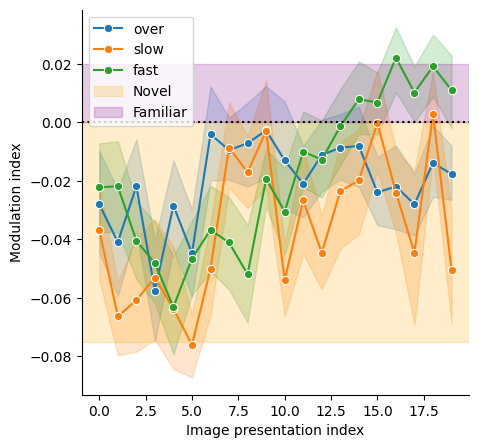

In [19]:
fig,ax = plt.subplots(ncols = 1, figsize =(5,5), sharex=True, sharey=True)
sns.lineplot(x='timestamp', y='mi',  data=df, marker='o', ax=ax, errorbar=('ci', 68), hue='learning') #'sd'
ax.axhline(0, linestyle=':', color='black')
ax.set_ylabel('Modulation index')
ax.set_xlabel('Image presentation index')
ax.axhspan(-0.075, 0, color='orange', alpha=0.2,label='Novel')  # Negative novel
ax.axhspan(0, 0.02, color='purple', alpha=0.2, label='Familiar')   # Positive familiar
ax.legend()
sns.despine()

In [20]:
df.groupby('learning')['mouse_id'].nunique()

learning
fast    12
over    10
slow    10
Name: mouse_id, dtype: int64

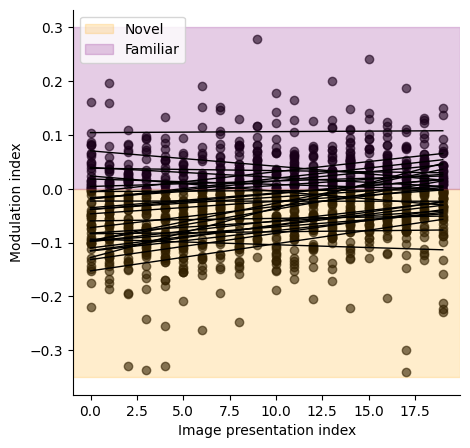

In [22]:
fig,ax = plt.subplots(ncols = 1, figsize =(5,5), sharex=True, sharey=True)

slopes=[]
for subj in df.subject.unique():

    X = df.loc[df['subject']==subj]['timestamp'].values.reshape(-1, 1) #sckitlearn needs 2D array for x Nsamples Nfeatures, we only have one feature
    y = df.loc[df['subject']==subj]['mi'].values

    # Fit regression
    reg = LinearRegression().fit(X, y)
    slope = reg.coef_[0]
    slopes.append(slope)

    # Get line for plotting
    x_pred = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
    y_pred = reg.predict(x_pred)

    # Plot scatter and regression line
    ax.scatter(X, y, alpha=0.6, color='black')
    #sns.stripplot(x='timestamp', y='mi',  data=df, ax=ax, color='black')
    ax.plot(x_pred, y_pred, linewidth=1, color='black')


#ax.axhline(0, linestyle=':', color='black')
ax.set_ylabel('Modulation index')
ax.set_xlabel('Image presentation index')
ax.axhspan(-0.35, 0, color='orange', alpha=0.2,label='Novel')  # Negative novel
ax.axhspan(0, 0.3, color='purple', alpha=0.2, label='Familiar')   # Positive familiar
ax.legend() 
sns.despine()


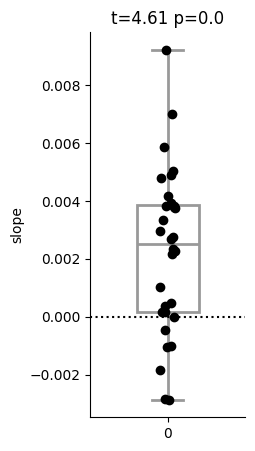

In [47]:
# plot slopes
fig, ax = plt.subplots(figsize =(2,5))

to_plot = {'slope':slopes, 'x_value':[0]*len(slopes)}
to_plot = pd.DataFrame(to_plot)

sns.stripplot(x='x_value', y= 'slope',  linewidth=2, data=to_plot, dodge=True, color='black')
sns.boxplot(x='x_value', y= 'slope',  linewidth=2, data=to_plot, color='white')
ax.axhline(0, linestyle=':', color='black')
t_stat, p_val = ttest_1samp(to_plot.slope, popmean=0)
ax.set_title("t="+str(round(t_stat, 2))+" p="+str(round(p_val, 3)))
ax.set_xlim(-1, 1)
ax.set_xlabel('')
sns.despine()


/opt/conda/lib/python3.9/site-packages/seaborn/matrix.py:1124: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


<Figure size 600x500 with 0 Axes>

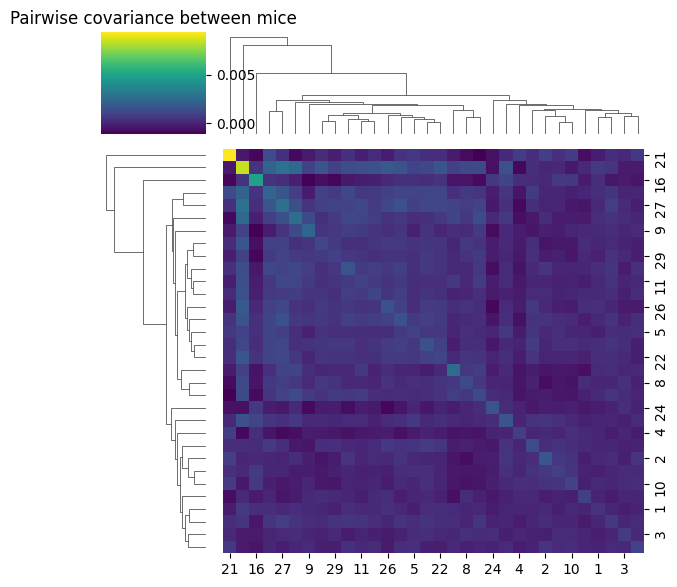

In [48]:
# avereage across images
to_plot = MI.mean(axis=1) # Nmice, Ntimepoints

# Covariance matrix: cov across rows (variables = mice, observations = columns)
C = np.cov(to_plot, rowvar=True, bias=False)

# Plot as heatmap
plt.figure(figsize=(6, 5))
#sns.heatmap(C, cmap="viridis", square=True)
sns.clustermap(C, cmap="viridis", figsize=(6,6), square=True)
plt.title("Pairwise covariance between mice")
plt.tight_layout()
plt.show()

In [ ]:
## check genotype, check timing vs visual strategy, pupil-size, running speed

Index(['mouse_id', 'training_until_ready', 'behavior_session_id',
       'date_of_acquisition', 'session_type', 'ecephys_session_id'],
      dtype='object')

corr(x,y)=σx​σy​cov(x,y)​

In [ ]:
# avereage across images
to_plot = MI.mean(axis=1) # Nmice, Ntimepoints

# Covariance matrix: cov across rows (variables = mice, observations = columns)
C = np.cov(to_plot, rowvar=True, bias=False)

# Plot as heatmap
plt.figure(figsize=(6, 5))
#sns.heatmap(C, cmap="viridis", square=True)
sns.clustermap(C, cmap="viridis", figsize=(6,6), square=True)
plt.title("Pairwise covariance between mice")
plt.tight_layout()
plt.show()

In [ ]:
#difference first lasts

first_threshold = 4
df2 = []

for subj, g in df.groupby("subject"):
    # Early window (timestamp < 4)
    first_mean = g.loc[g["timestamp"] < first_threshold, "mi"].mean()
    #df2.append({"subject": subj, "mi": first_mean, "time_c": "First"})

    # Late window (last 4 timepoints)
    last_threshold = g["timestamp"].max() - first_threshold
    last_mean = g.loc[g["timestamp"] > last_threshold, "mi"].mean()
    #df2.append({"subject": subj, "mi": last_mean, "time_c": "Last"})

    df2.append({"subject": subj, "first": first_mean, "last": last_mean})

df2 = pd.DataFrame(df2)
df2['diff_'] = df2['last'] - df2['first']


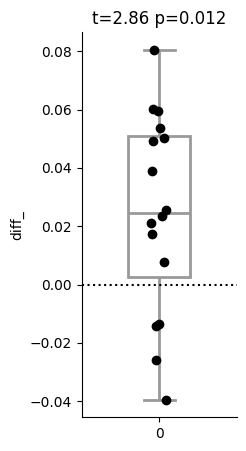

In [ ]:


fig, ax = plt.subplots(figsize =(2,5))
df2['x_value'] = 0
sns.stripplot(x='x_value', y= 'diff_',  linewidth=2, data=df2, dodge=True, color='black')
sns.boxplot(x='x_value', y= 'diff_',  linewidth=2, data=df2, color='white')
ax.axhline(0, linestyle=':', color='black')
t_stat, p_val = ttest_1samp(df2.diff_, popmean=0)
ax.set_title("t="+str(round(t_stat, 2))+" p="+str(round(p_val, 3)))
ax.set_xlim(-1, 1)
ax.set_xlabel('')
sns.despine()


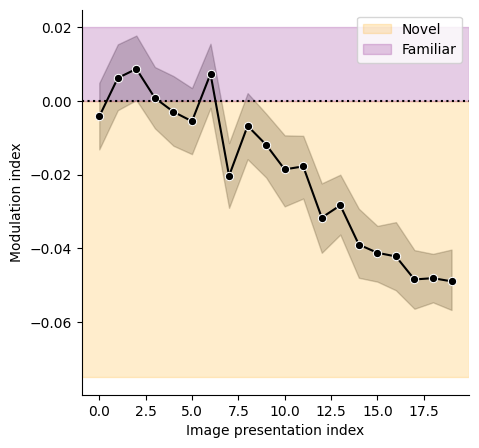

In [27]:
fig,ax = plt.subplots(ncols = 1, figsize =(5,5), sharex=True, sharey=True)
sns.lineplot(x='timestamp', y='mi',  data=df, marker='o', ax=ax, errorbar=('ci', 68), color='black')
ax.axhline(0, linestyle=':', color='black')
ax.set_ylabel('Modulation index')
ax.set_xlabel('Image presentation index')
ax.axhspan(-0.075, 0, color='orange', alpha=0.2,label='Novel')  # Negative novel
ax.axhspan(0, 0.02, color='purple', alpha=0.2, label='Familiar')   # Positive familiar
ax.legend()
sns.despine()

In [ ]:
#save all spike_times active phase session GGH
# safe brain region


(4, 2, 2, 20)

In [ ]:
# RSA --> COSYNE SIMILARITY

35